### Data Formatting
- Reshape the images to (100,100,3)
- Save the transformed images as JPEG files in a separate directory.

In [1]:
import cv2 as cv
import numpy as np
import os
import random
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
output_path = 'resized_images'
if not os.path.isdir(output_path): 
    
    os.makedirs(output_path) 

In [3]:
input_path = 'orig_images'
Path(output_path).mkdir(parents=True, exist_ok=True)
imagelist = ['0001.jpg', '0002.jpg', '0003.jpg', '0007.jpg', '0008.jpg', '0009.jpg', '0010.jpg', '0011.jpg', '0020.jpg', '0030.jpg']

shape = [100,100]

for image in imagelist:
	resized_img = cv.resize(cv.imread(input_path+"/"+image), shape)
	cv.imwrite(output_path+'/'+image, resized_img)

## Data Augmentation

### 1. Randomly put a black patch over a portion of the image

In [4]:
patch_shape = [i/8 for i in shape]

In [8]:
def patch_img_random(image, radius):
    rand_loc_x = random.randint(0, shape[0]-1)
    rand_loc_y = random.randint(0, shape[1]-1)
    image = cv.circle(image, (rand_loc_x, rand_loc_y), radius, color=(0,0,0), thickness=-1)
    return image

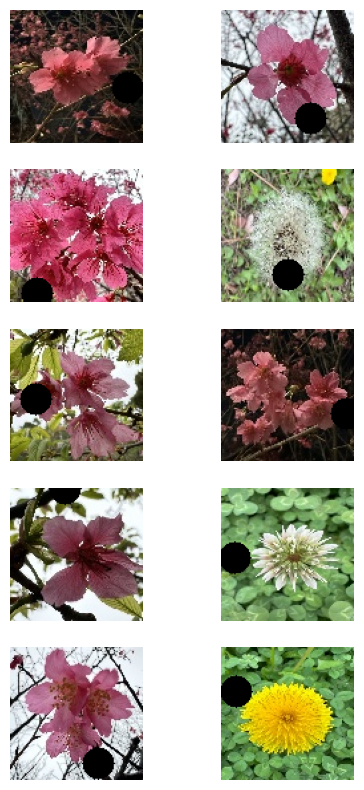

In [9]:
output_augment_path = 'augmented_images'
if not os.path.isdir(output_augment_path): 

		os.makedirs(output_augment_path) 

fig = plt.figure(figsize=(5,10))

row = 5
col = 2

imagelist = ['0001.jpg', '0002.jpg', '0003.jpg', '0007.jpg', '0008.jpg', '0009.jpg', '0010.jpg', '0011.jpg', '0020.jpg', '0030.jpg']
for i, imagename in enumerate(imagelist):
    image = cv.imread(output_path+"/"+imagename)
    image = patch_img_random(image, image.shape[0]//8)
    cv.imwrite(output_augment_path+'/'+'patch'+imagename, image)
    
    fig.add_subplot(row, col, i+1)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.axis("off")
	

### 2. Shift an image sideward or upwards.

In [11]:
def shift_image(image, horz_shift, vert_shift):
	translation_matrix = np.float32([ [1,0,horz_shift ], \
									  [0,1,vert_shift ]])
 
	new_image = cv.warpAffine(image, translation_matrix, (image.shape[0], image.shape[1]))
	return new_image

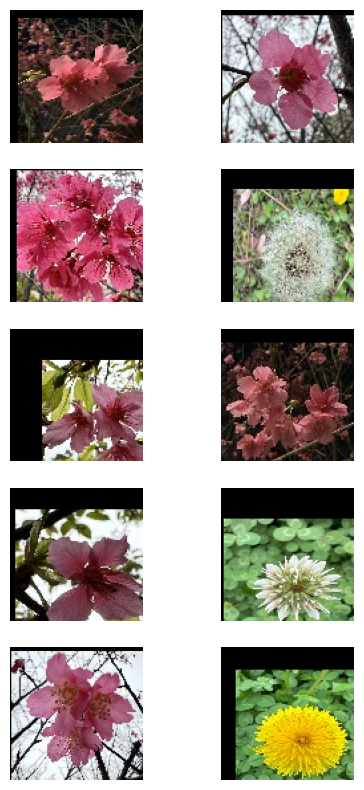

In [13]:
imagelist = ['0001.jpg', '0002.jpg', '0003.jpg', '0007.jpg', '0008.jpg', '0009.jpg', '0010.jpg', '0011.jpg', '0020.jpg', '0030.jpg']

fig = plt.figure(figsize=(5,10))

for i, imagename in enumerate(imagelist):
    image = cv.imread(output_path+"/"+imagename)
    
    rand_x = random.randint(0,image.shape[0]) // 4
    rand_y = random.randint(0,image.shape[1]) // 4
    
    image = shift_image(image, rand_x, rand_y)
    cv.imwrite(output_augment_path+'/'+'shift'+imagename, image)
    
    fig.add_subplot(row, col, i+1)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.axis("off")

### 3. Rotate an image either for

In [19]:
def shift_image(image, angle):
	rotation_matrix = cv.getRotationMatrix2D((image.shape[1]//2, image.shape[0]//2), angle, 1)
 
	new_image = cv.warpAffine(image, rotation_matrix, (image.shape[0], image.shape[1]))
	return new_image

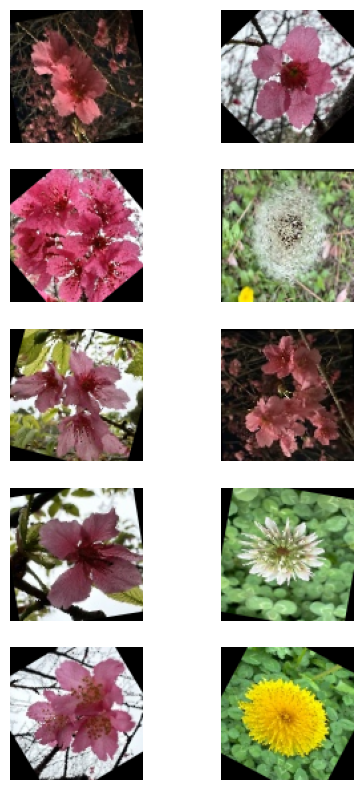

In [20]:
imagelist = ['0001.jpg', '0002.jpg', '0003.jpg', '0007.jpg', '0008.jpg', '0009.jpg', '0010.jpg', '0011.jpg', '0020.jpg', '0030.jpg']

fig = plt.figure(figsize=(5,10))

for i, imagename in enumerate(imagelist):
    image = cv.imread(output_path+"/"+imagename)
    img_shape = image.shape
    
    image = shift_image(image, random.randint(0,360))
    cv.imwrite(output_augment_path+'/'+'rotate'+imagename, image)
    
    fig.add_subplot(row, col, i+1)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.axis("off")

### 4. Flip an image either vertically or horizontally.

In [22]:
def flip_image(image, axis):
	image = cv.flip(image, axis)
	return image

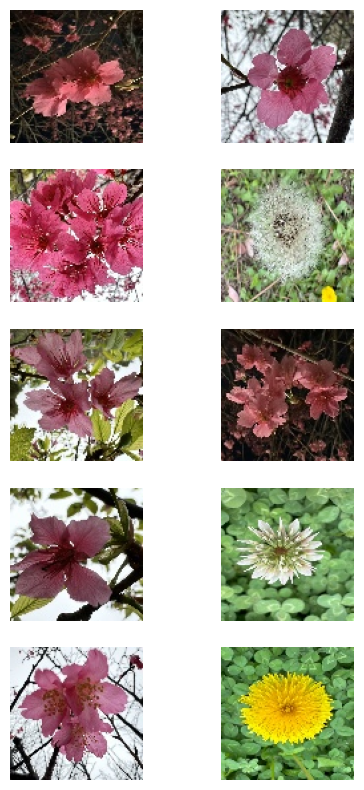

In [23]:
imagelist = ['0001.jpg', '0002.jpg', '0003.jpg', '0007.jpg', '0008.jpg', '0009.jpg', '0010.jpg', '0011.jpg', '0020.jpg', '0030.jpg']

fig = plt.figure(figsize=(5,10))

for i, imagename in enumerate(imagelist):
    image = cv.imread(output_path+"/"+imagename)
    img_shape = image.shape
    
    image = flip_image(image, random.randint(-1,1))
    cv.imwrite(output_augment_path+'/'+'flip'+imagename, image)
    
    fig.add_subplot(row, col, i+1)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.axis("off")

### 5. Combine all augmentations into 1 parameterized function

In [33]:
def augment_image(image, patch_radius=0, horz_shift=0, vert_shift=0, rot_angle=0, flip_code=0):

	#step 1: patch the image
	patched_img = patch_img_random(image, patch_radius)

	#note: the previously made functions are 

	#step 2: shift the image
	shift_transform = np.float32([[1, 0, horz_shift],
								  [0, 1, vert_shift]])
 
	#step 3: rotate the image
	rot_transform = cv.getRotationMatrix2D((image.shape[1]//2, image.shape[0]//2), rot_angle, 1)
 
	#step 3.5: combine transformation matrices
	#add omitted row [0,0,1] to affine transformation matrices to apply matrix mult
	T0 = np.vstack((shift_transform, np.array([0,0,1])))
	T1 = np.vstack((rot_transform, np.array([0,0,1])))
	final_transform = T1 @ T0
	final_transform = final_transform[0:2, :] #re-omit last row
 
	transformed_img = cv.warpAffine(patched_img, final_transform, (image.shape[0], image.shape[1]))
 
	#step 4: flip image along axis
	flipped_img = cv.flip(transformed_img, flip_code)

	final_img = flipped_img
	return final_img

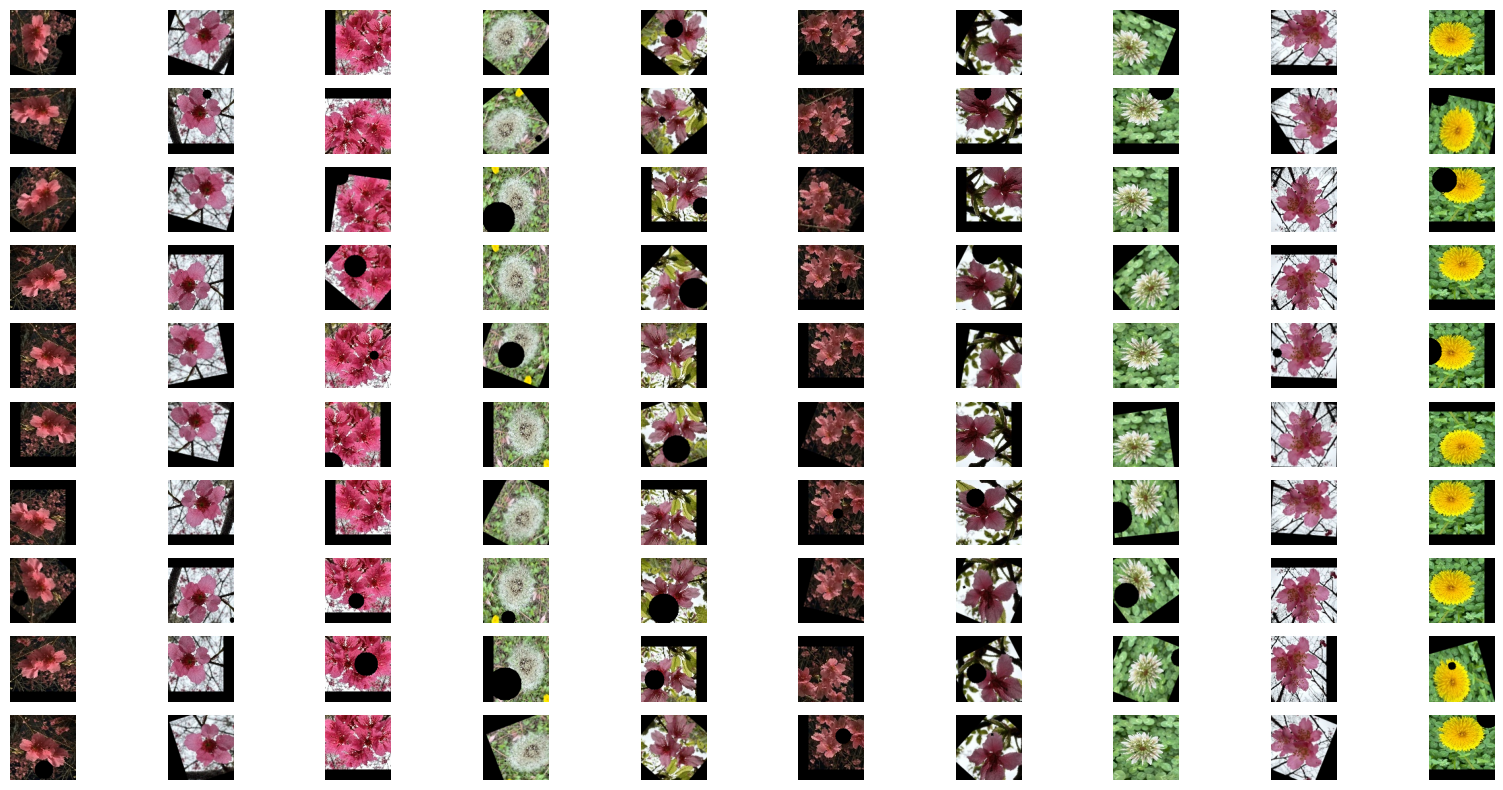

In [43]:

input_path = 'resized_images'
output_path = 'final_augment_images'

if not os.path.isdir(output_path): 

		os.makedirs(output_path) 

fig = plt.figure(figsize=(20,10))
row = 10
col = 10

imagelist = ['0001.jpg', '0002.jpg', '0003.jpg', '0007.jpg', '0008.jpg', '0009.jpg', '0010.jpg', '0011.jpg', '0020.jpg', '0030.jpg']
for i in range(0,10):
	for j, imagename in enumerate(imagelist):
		image = cv.imread(input_path+"/"+imagename)
		shape_x, shape_y = image.shape[0:2]
  
		patch_radius = random.randint(0,shape_x//4) if bool(random.getrandbits(1)) else 0
  
		horz_shift = random.randint(shape_x//6, shape_x//6) if bool(random.getrandbits(1)) else 0
		vert_shift = random.randint(shape_y//6, shape_y//6) if bool(random.getrandbits(1)) else 0
	
		rot_angle  = random.randrange(0,360) if bool(random.getrandbits(1)) else 0
  
		flip_code = random.randint(-1,1)
  
		result_image = augment_image(image, patch_radius, horz_shift, vert_shift, rot_angle, flip_code)

		idx = (i*10)+j
		cv.imwrite(output_path+"/"+str(idx)+".jpg", result_image)
		fig.add_subplot(row, col, idx+1)
		plt.imshow(cv.cvtColor(result_image, cv.COLOR_BGR2RGB))
		plt.axis("off")
		

## Guide Questions:

1. Define Data Augmentation and discuss its importance and the importance of understanding digital image processing for such an activity.

Data Augmentation is the process of modifying a dataset's items to artificially generate a new set of data, without the need to gather new pieces of data. This is important in many machine learning tasks where existing datasets are small and difficult to gather. These new augmented data exist to introduce noise into a dataset, with which a model would be able to learn better features and elements within the samples to achieve better accuracy when encountering new data.

Digital image processing knowledge is crucial in performing data augmentation as shown above -- An image can be manipulated in a variety of ways to change how it appears and how its data is arranged, all while remaining the same original data's key features. This is what helps machine learning models avoid overfitting to its training data, making it more accurate under new scenarios which can be noisy and taken in a variety of ways.

2. What other data augmentation techniques are applicable and not applicable to the dataset you have produced? Why?

Other data augmentation techniques would be to change the color distribution of the images to change its brightness, hue, and saturation. These would help increase variation in features, leading to a better trained model.

Another possible augmentation would have been to apply a filter kernel over the image to directly change the actual pixel values of the image, however because the new dataset has already omitted pixels out of the original image certain parts of the image would be filtered inconsistently, like the edge of the shifted/rotated image, or around the generated patches. This should be performed before data is omitted to prevent potential feature losses. Scaling and reshaping the image would also not be applicable depending on the input scheme of the model.